# Задача 2: Аналіз семантики товарів

### Мета:

Розробити систему для визначення емоційного відтінку та
виявлення цін у текстових коментарях.

### Опис:
1. У нашій базі є інформація про числові оцінки товару з текстовим коментарем. Потрібно створити алгоритм, який буде здатен класифікувати коментар за емоційним забарвленням на позитивний/негативний чи нейтральний.

2. Розробити підхід, який буде знаходити числове значення ціни з будь якого коментаря. Ціни можуть бути зазначені у місцевій валюті або доларах США.



---



## Дістаємо інформацію

In [1]:
import os
import zipfile


direct = r"/content/drive/MyDrive/Colab Notebooks/SMART_business/S_Data"
os.listdir(direct)

['customers.csv',
 'dicts.zip',
 'geolocation.csv',
 'order_items.csv',
 'order_payments.csv',
 'order_reviews.csv',
 'orders.csv',
 'product_category_name_translation.csv',
 'products.csv',
 'sellers.csv',
 'dicts']

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df_customers = pd.read_csv(f"{direct}/customers.csv")
df_geolocation = pd.read_csv(f"{direct}/geolocation.csv")
order_items = pd.read_csv(f"{direct}/order_items.csv")
order_payments = pd.read_csv(f"{direct}/order_payments.csv")
order_reviews = pd.read_csv(f"{direct}/order_reviews.csv")
orders = pd.read_csv(f"{direct}/orders.csv")
product_eng = pd.read_csv(f"{direct}/product_category_name_translation.csv")
df_products = pd.read_csv(f"{direct}/products.csv")
df_sellers = pd.read_csv(f"{direct}/sellers.csv")

In [ ]:
dicts = f"{direct}/dicts"

def open_dict(file_name):
  result = {}
  with open(f"{dicts}/{file_name}", "r", encoding="utf-8") as f:
    data = f.readlines()

  for i in data:
    i = i.split(";")
    result[i[0]] = i[1][:-1]

  return result

In [ ]:
for i in os.listdir(dicts)[1:]:
  data = open_dict(i)
  print(f"\n --- {i} ---")

  for k, v in data.items():
    print(f"{k}: {v}")


 --- orders_dict.csv ---
order_id: unique identifier of the order.
customer_id: key to the customer dataset. Each order has a unique customer_id.
order_status: Reference to the order status (delivered, shipped, etc).
order_purchase_timestamp: Shows the purchase timestamp.
order_approved_at: Shows the payment approval timestamp.
order_delivered_carrier_date: Shows the order posting timestamp. When it was handled to the logistic partner.
order_delivered_customer_date: Shows the actual order delivery date to the customer.
order_estimated_delivery_date: Shows the estimated delivery date that was informed to customer at the purchase moment

 --- customers_dict.csv ---
customer_id: key to the orders dataset. Each order has a unique customer_id
customer_unique_id: unique identifier of a customer.
customer_zip_code_prefix: first five digits of customer zip code
customer_city: customer city name
customer_state: customer state
: 

 --- order_items_dict.csv ---
order_id: order unique identifier


In [ ]:
order_reviews

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99995,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99996,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99997,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13
99998,be360f18f5df1e0541061c87021e6d93,f8bd3f2000c28c5342fedeb5e50f2e75,1,NaN,Solicitei a compra de uma capa de retrovisor c...,2017-12-15 00:00:00,2017-12-16 01:29:43


In [3]:
df = pd.merge(order_reviews, order_items, on="order_id")
df = pd.merge(df, df_products, on="product_id")
df = pd.merge(df, product_eng, on="product_category_name")
print(f"{df.shape}\n{df.columns}")

(111686, 22)
Index(['review_id', 'order_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english'],
      dtype='object')


## Основна таблиця

In [4]:
df = df[["review_id",
         "order_id",
         "review_score",
         "review_comment_title",
         "review_comment_message",
         "review_creation_date",
         "product_id",
         "price",
         "product_category_name_english"]]

df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,product_id,price,product_category_name_english
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,fd25ab760bfbba13c198fa3b4f1a0cd3,185.00,sports_leisure
1,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,fd25ab760bfbba13c198fa3b4f1a0cd3,185.00,sports_leisure
2,e2655da8bccce2ddc2f43cc2c80d24f3,19721d59a9764437477eff0730b48665,5,NaN,NaN,2018-04-10 00:00:00,fd25ab760bfbba13c198fa3b4f1a0cd3,185.00,sports_leisure
3,cb18f53b563f0bdeb76be0376ddd6b6a,efd626e6a12a82d76e456e34093f8356,5,NaN,NaN,2017-12-28 00:00:00,fd25ab760bfbba13c198fa3b4f1a0cd3,185.00,sports_leisure
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,3880d25d502b15b1de6fddc42ad1d67a,1199.00,sports_leisure
...,...,...,...,...,...,...,...,...,...
111681,ad0de1dda4fa03e8efb68c481b31ebf8,2ef4a11b6e24fdfbb43b92cb5f95edff,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",2018-07-28 00:00:00,9c313adb4b38a55b092f53f83f78be9e,19.00,arts_and_craftmanship
111682,ad0de1dda4fa03e8efb68c481b31ebf8,2ef4a11b6e24fdfbb43b92cb5f95edff,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",2018-07-28 00:00:00,eacb104882d39ffb53140b1d1860a7c3,39.90,arts_and_craftmanship
111683,a6aa76a7e7d8d5cc16f841cfb1619dbc,1c3f752b9a4d09bf1e016439a427d5f8,5,NaN,NaN,2018-08-22 00:00:00,56a1efb30499b4dffd45c8d655199b11,16.49,arts_and_craftmanship
111684,82ec4a1c6f0134f607033e23431ee298,2c4ada2e75c2ad41dd93cebb5df5f023,4,NaN,Envio muito rápido. Recomendo.,2017-02-15 00:00:00,6c7a0a349ad11817745e3ad58abd5c79,183.29,security_and_services


## Аналіз даних

In [5]:
data = df[["review_score", "review_comment_title", "review_comment_message", "price", "product_category_name_english", "review_creation_date"]]
data

,review_score,review_comment_title,review_comment_message,price,product_category_name_english,review_creation_date
0,4,NaN,NaN,185.00,sports_leisure,2018-01-18 00:00:00
1,4,NaN,NaN,185.00,sports_leisure,2018-01-18 00:00:00
2,5,NaN,NaN,185.00,sports_leisure,2018-04-10 00:00:00
3,5,NaN,NaN,185.00,sports_leisure,2017-12-28 00:00:00
4,5,NaN,Parabéns lojas lannister adorei comprar pela I...,1199.00,sports_leisure,2018-03-01 00:00:00
...,...,...,...,...,...,...
111681,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",19.00,arts_and_craftmanship,2018-07-28 00:00:00
111682,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",39.90,arts_and_craftmanship,2018-07-28 00:00:00
111683,5,NaN,NaN,16.49,arts_and_craftmanship,2018-08-22 00:00:00
111684,4,NaN,Envio muito rápido. Recomendo.,183.29,security_and_services,2017-02-15 00:00:00


In [ ]:
data.describe()

,review_score,price
count,111686.000000,111686.000000
mean,4.018418,120.582645
std,1.397678,183.016435
min,1.000000,0.850000
25%,4.000000,39.900000
50%,5.000000,74.900000
75%,5.000000,134.900000
max,5.000000,6735.000000


In [ ]:
print(data.isnull().sum())

review_score                         0
review_comment_title             98153
review_comment_message           63827
price                                0
product_category_name_english        0
review_creation_date                 0
dtype: int64


In [ ]:
data[~data["review_comment_title"].isnull()]

,review_score,review_comment_title,review_comment_message,price,product_category_name_english,review_creation_date
7,4,Muito bom.,Recebi exatamente o que esperava. As demais en...,34.90,sports_leisure,2018-06-07 00:00:00
10,5,Excelente,NaN,37.00,sports_leisure,2018-07-04 00:00:00
26,1,Entrega faltando,Comprei dois produtos na loja só veio um. É no...,76.00,sports_leisure,2018-07-21 00:00:00
27,4,Recebi o produto no prazo,Entregue no prazo.,76.00,sports_leisure,2018-08-15 00:00:00
40,1,Não recomendo,O produto chegou sem problemas. Mas ele não é ...,179.00,sports_leisure,2018-04-25 00:00:00
...,...,...,...,...,...,...
111675,1,Produto ainda não chegou,Recebi um pacote com apenas um item do que com...,9.80,arts_and_craftmanship,2018-07-24 00:00:00
111678,5,Pedido entregue,Recebi em 3 dias muito rápido tudo perfeito pa...,289.49,arts_and_craftmanship,2018-08-25 00:00:00
111679,5,Otimo,"Muito rapida a entrega ,perfeito",39.90,arts_and_craftmanship,2018-07-26 00:00:00
111681,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",19.00,arts_and_craftmanship,2018-07-28 00:00:00


In [ ]:
data[data["review_score"] == 1]

,review_score,review_comment_title,review_comment_message,price,product_category_name_english,review_creation_date
8,1,NaN,Tem que ser mais rapido a entrega,34.90,sports_leisure,2018-04-06 00:00:00
26,1,Entrega faltando,Comprei dois produtos na loja só veio um. É no...,76.00,sports_leisure,2018-07-21 00:00:00
40,1,Não recomendo,O produto chegou sem problemas. Mas ele não é ...,179.00,sports_leisure,2018-04-25 00:00:00
50,1,NaN,Não funciona não faz sincronismo,149.90,sports_leisure,2017-09-17 00:00:00
67,1,NaN,muita demorada..enrrolacao total.,149.90,sports_leisure,2017-09-03 00:00:00
...,...,...,...,...,...,...
111659,1,NaN,NaN,49.90,fashion_childrens_clothes,2017-09-03 00:00:00
111669,1,Produto chegou quebrado,Produto chegou quebrado e não consigo realizar...,126.49,arts_and_craftmanship,2018-08-21 00:00:00
111672,1,Mercadoria quebrada,O produto chegou com a voltagem errada e quebr...,129.49,arts_and_craftmanship,2018-08-10 00:00:00
111675,1,Produto ainda não chegou,Recebi um pacote com apenas um item do que com...,9.80,arts_and_craftmanship,2018-07-24 00:00:00


In [ ]:
print(f"{data[data['review_score'] == 2].shape}")
print(f"{data[data['review_score'] == 3].shape}")
print(f"{data[data['review_score'] == 4].shape}")
print(f"{data[data['review_score'] == 5].shape}")

(3916, 6)
(9439, 6)
(21075, 6)
(62774, 6)


Для точності аналізу саме review_comment_message варто прибрати рядки зі значеннями "NaN"

In [55]:
data_1 = data[~data["review_comment_message"].isnull()]
data_1

,review_score,review_comment_title,review_comment_message,price,product_category_name_english,review_creation_date
4,5,NaN,Parabéns lojas lannister adorei comprar pela I...,1199.00,sports_leisure,2018-03-01 00:00:00
5,5,NaN,Estou satisfeito com a compra. A empresa é sér...,1199.00,sports_leisure,2017-12-12 00:00:00
6,5,NaN,Tudo correu dentro do previsto. Obrigada!,1199.00,sports_leisure,2018-02-23 00:00:00
7,4,Muito bom.,Recebi exatamente o que esperava. As demais en...,34.90,sports_leisure,2018-06-07 00:00:00
8,1,NaN,Tem que ser mais rapido a entrega,34.90,sports_leisure,2018-04-06 00:00:00
...,...,...,...,...,...,...
111679,5,Otimo,"Muito rapida a entrega ,perfeito",39.90,arts_and_craftmanship,2018-07-26 00:00:00
111681,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",19.00,arts_and_craftmanship,2018-07-28 00:00:00
111682,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",39.90,arts_and_craftmanship,2018-07-28 00:00:00
111684,4,NaN,Envio muito rápido. Recomendo.,183.29,security_and_services,2017-02-15 00:00:00


In [22]:
print(f'data: {data["review_score"].value_counts()}\n\ndata_1: {data_1["review_score"].value_counts()}')

data: review_score
5    62774
4    21075
1    14482
3     9439
2     3916
Name: count, dtype: int64

data_1: review_score
5    22541
1    11437
4     6698
3     4380
2     2803
Name: count, dtype: int64


Бачимо, що більшість покупців ставлять найвищі оцінки без коментарів.

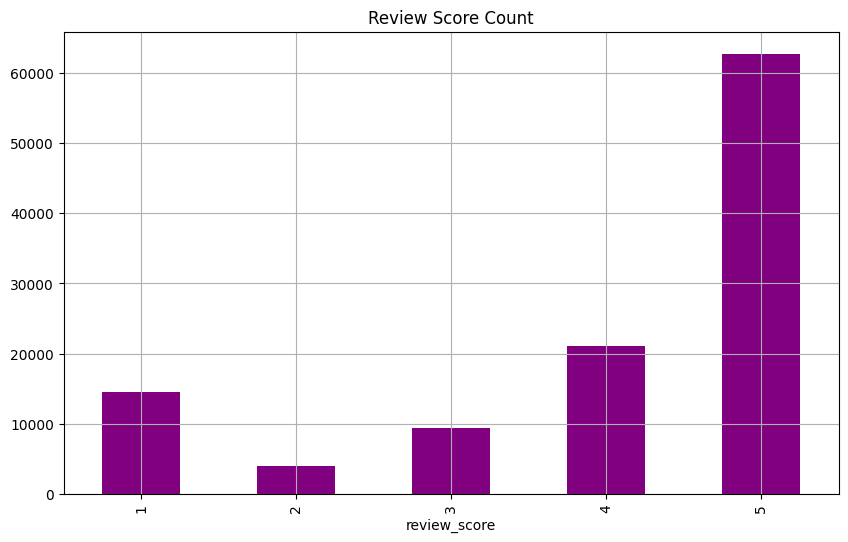

In [38]:
plt.figure(figsize=(10,6))
data["review_score"].value_counts().sort_index().plot(kind="bar",
                                                      title="Review Score Count",
                                                      color="purple")
plt.grid()
plt.show()

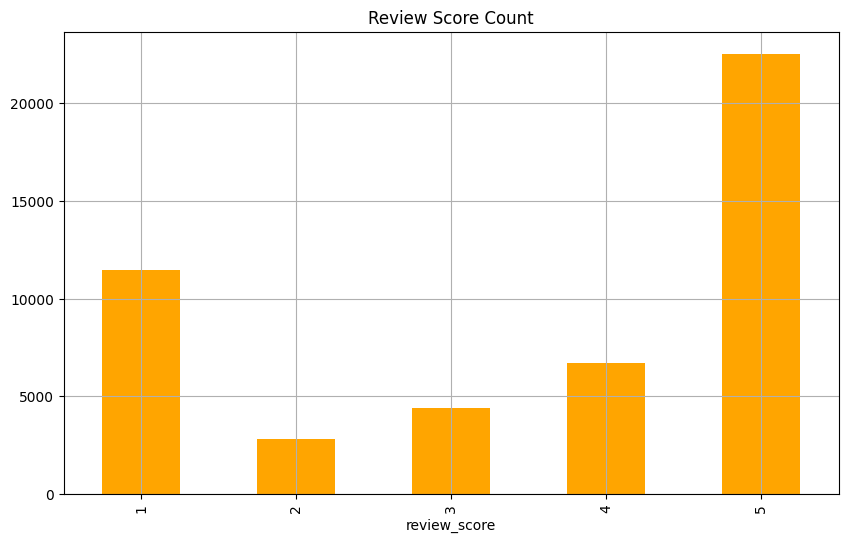

In [41]:
plt.figure(figsize=(10, 6))
data_1["review_score"].value_counts().sort_index().plot(kind="bar",
                                                      title="Review Score Count",
                                                      color="orange")
plt.grid()
plt.show()

(-0.5, 999.5, 499.5, -0.5)

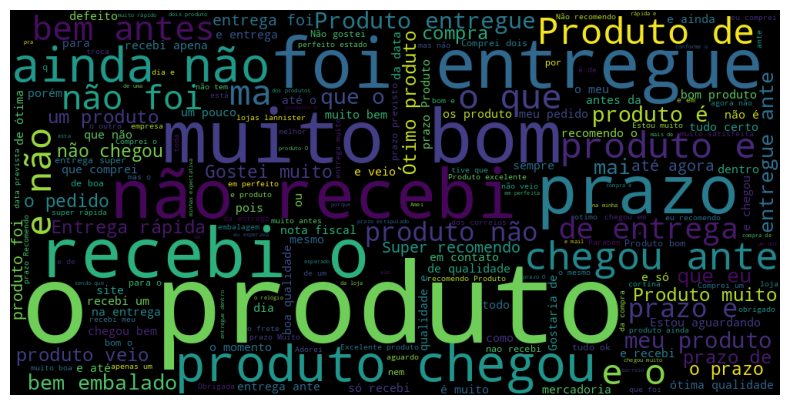

In [42]:
from wordcloud import WordCloud, STOPWORDS


t = (" ".join(data_1["review_comment_message"]))

wordcloud = WordCloud(width = 1000, height = 500).generate(t)
plt.figure(figsize=(15, 5))
plt.imshow(wordcloud)
plt.axis("off")

Побудуємо дві моделі. Наївний Байєсівський класифікатор та за допомогою бібліотек NLTK і TextBlob

## Модель Naive Bayes

Спробуємо передбачити класифікацію коментарів за поставленими оцінками.

Тобто категоріально:
* rates 1-2: negative (-1)

* rate 3: neutral (0)

* rates 4-5: positive (1)

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB


In [59]:
X = data_1["review_comment_message"]
y = data_1["review_score"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (38287,), X_test: (9572,), y_train: (38287,), y_test: (9572,)


Переводимо слова у вектори

In [60]:
vectorizer = TfidfVectorizer()

tfid_train = vectorizer.fit_transform(X_train)
tfid_test = vectorizer.fit_transform(X_test)

print(f"tfid_X_train: {tfid_train.shape}, tfid_X_test: {tfid_test.shape}")
print(f"y_train: {y_train.shape}, y_test: {y_test.shape}")

tfid_X_train: (38287, 14540), tfid_X_test: (9572, 7348)
y_train: (38287,), y_test: (9572,)


In [ ]:
# Кодування категорій, в нашому випадку не обов'язково

# label_enc = LabelEncoder()
# cat_df = data_1[["review_score", "review_comment_message"]]

# cat_df["Label Encoder"] = label_enc.fit_transform(data_1["review_score"])
# cat_df

In [85]:
nb = MultinomialNB()
nb_fit = nb.fit(tfid_train, y_train)

tr_nb_acc = nb_fit.score(tfid_train, y_train)
nb_tr_pred = nb_fit.predict(tfid_train)

print(f"filter train accuracy: {tr_nb_acc}")


nb_fit = nb.fit(tfid_test, y_test)

te_nb_acc = nb_fit.score(tfid_test, y_test)
nb_te_pred = nb_fit.predict(tfid_test)

print(f"filter test accuracy: {te_nb_acc}")


filter train accuracy: 0.6987228040849375
filter test accuracy: 0.6829293773506059


Взагалі, всередині функції .score для X_train, y_train має стояти X_test, проте у мене чомусь викликається помилка розмірності

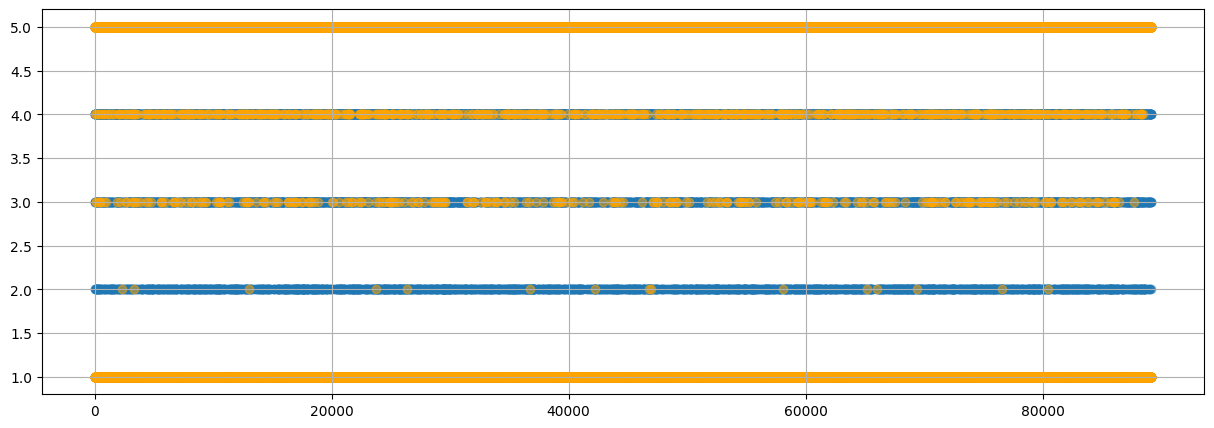

In [82]:
plt.figure(figsize=(15, 5))
plt.scatter(data_1[:38287].index, y_train, alpha=0.5)
plt.scatter(data_1[:38287].index, nb_tr_pred, alpha=0.5, color="orange")
plt.grid()
plt.show()

In [138]:
data_1.head()

,review_score,review_comment_title,review_comment_message,price,product_category_name_english,review_creation_date
4,5,NaN,Parabéns lojas lannister adorei comprar pela I...,1199.0,sports_leisure,2018-03-01 00:00:00
5,5,NaN,Estou satisfeito com a compra. A empresa é sér...,1199.0,sports_leisure,2017-12-12 00:00:00
6,5,NaN,Tudo correu dentro do previsto. Obrigada!,1199.0,sports_leisure,2018-02-23 00:00:00
7,4,Muito bom.,Recebi exatamente o que esperava. As demais en...,34.9,sports_leisure,2018-06-07 00:00:00
8,1,NaN,Tem que ser mais rapido a entrega,34.9,sports_leisure,2018-04-06 00:00:00


In [139]:
categories = data_1["review_score"].apply(lambda x: "positive" if x > 3 else "negative" if x < 3 else "neutral")
categories.head()

,review_score
4,positive
5,positive
6,positive
7,positive
8,negative


## Модель NLTK

In [ ]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from nltk.corpus import stopwords

nltk.download("punkt")
nltk.download("stopwords")
nltk.download("words")

In [ ]:
nltk.download("averaged_perceptron_tagger")

In [ ]:
nltk.download("maxent_ne_chunker")

In [236]:
text = data_1["review_comment_message"][:5000]
print(text.shape)
text = text.drop_duplicates()
print(text.shape)
text.head()

(5000,)
(3986,)


,review_comment_message
4,Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa
5,Estou satisfeito com a compra. A empresa é séria e respeita o consumidor.
6,Tudo correu dentro do previsto. Obrigada!
7,"Recebi exatamente o que esperava. As demais encomendas de outros vendedores atrasaram, mas esta chegou no prazo."
8,Tem que ser mais rapido a entrega


In [237]:
text = [f"{i.strip()}" for i in text]
print(len(text))

3986


In [240]:
tokens = []
for i in text:
  tokens.extend(nltk.word_tokenize(i))

print(tokens[:10])

['Parabéns', 'lojas', 'lannister', 'adorei', 'comprar', 'pela', 'Internet', 'seguro', 'e', 'prático']


In [241]:
print(len(tokens))

56535


In [242]:
tagged = nltk.pos_tag(tokens)
print(tagged[:10])

[('Parabéns', 'NNP'), ('lojas', 'NN'), ('lannister', 'NN'), ('adorei', 'NN'), ('comprar', 'NN'), ('pela', 'JJ'), ('Internet', 'NNP'), ('seguro', 'NN'), ('e', 'NN'), ('prático', 'NN')]


In [ ]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

### Vader (Valence Aware Dictionary and sEntiment Reasoner)

In [247]:
nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [248]:
sia = SentimentIntensityAnalyzer()

In [169]:
data_1.tail()

,review_score,review_comment_title,review_comment_message,price,product_category_name_english,review_creation_date
111679,5,Otimo,"Muito rapida a entrega ,perfeito",39.90,arts_and_craftmanship,2018-07-26 00:00:00
111681,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",19.00,arts_and_craftmanship,2018-07-28 00:00:00
111682,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",39.90,arts_and_craftmanship,2018-07-28 00:00:00
111684,4,NaN,Envio muito rápido. Recomendo.,183.29,security_and_services,2017-02-15 00:00:00
111685,1,NaN,"boa tarde produto enviado errado, terei que me...",100.00,security_and_services,2017-09-29 00:00:00


In [249]:
example = data_1["review_comment_message"].values[-1]
example

'boa tarde produto enviado errado, terei que me deslocar aos correios pois moro em um condomínio tive receber, e ainda irei esperar chegar para so depois eu receber o produto correto, paguei via boleto'

In [250]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [251]:
example = data_1["review_comment_message"].values[-5]
example

'Muito rapida a entrega ,perfeito '

In [252]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [253]:
example = data_1["review_comment_message"].values[0]
example

'Parabéns lojas lannister adorei comprar pela Internet seguro e prático Parabéns a todos feliz Páscoa'

In [254]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Модель, здається, не працює. Можливо, ці приклади коментарів дійсно нейтральні. Можливо, є моменти з португальскою мовою. Можливо у мене помилки

In [286]:
example = data_1[data_1.review_comment_message == "Entrega super rápida!"].values[0][2]
example

'Entrega super rápida!'

In [287]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.323, 'pos': 0.677, 'compound': 0.636}

Все-таки працює :)

## Модель TextBlob

In [258]:
from textblob import TextBlob

In [272]:
df = data_1[["review_comment_message", "review_score"]]
df.head()

,review_comment_message,review_score
4,Parabéns lojas lannister adorei comprar pela I...,5
5,Estou satisfeito com a compra. A empresa é sér...,5
6,Tudo correu dentro do previsto. Obrigada!,5
7,Recebi exatamente o que esperava. As demais en...,4
8,Tem que ser mais rapido a entrega,1


In [260]:
text = df["review_comment_message"]
score = df["review_score"]

In [261]:
polarity = []

for i in text.values:
  analysis = TextBlob(i)
  polarity.append(analysis.sentiment.polarity)

In [273]:
df["polarity"] = polarity
df

<ipython-input-273-1cbfdfdff4b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["polarity"] = polarity


,review_comment_message,review_score,polarity
4,Parabéns lojas lannister adorei comprar pela I...,5,0.0
5,Estou satisfeito com a compra. A empresa é sér...,5,0.0
6,Tudo correu dentro do previsto. Obrigada!,5,0.0
7,Recebi exatamente o que esperava. As demais en...,4,0.0
8,Tem que ser mais rapido a entrega,1,0.0
...,...,...,...
111679,"Muito rapida a entrega ,perfeito",5,0.0
111681,"Um dos frisadores que comprei, especificamente...",3,0.0
111682,"Um dos frisadores que comprei, especificamente...",3,0.0
111684,Envio muito rápido. Recomendo.,4,0.0


In [ ]:
df["polarity"][df.polarity == 0] = 0
df["polarity"][df.polarity > 0] = 1
df["polarity"][df.polarity < 0] = -1


In [276]:
df.describe()

,review_score,polarity
count,47859.000000,47859.000000
mean,3.545415,0.058422
std,1.655579,0.281510
min,1.000000,-1.000000
25%,2.000000,0.000000
50%,4.000000,0.000000
75%,5.000000,0.000000
max,5.000000,1.000000


In [277]:
df_pos = df[df["polarity"] == 1]
df_pos

,review_comment_message,review_score,polarity
42,A bolsa térmica além de linda é super espaçosa...,5,1.0
53,Site super seguro pra compra e com entrega gar...,4,1.0
60,Entrega super rápida!,5,1.0
61,Entrega super rápida!,5,1.0
79,super recomendo\r\n,5,1.0
...,...,...,...
111385,Linda demais. Do jeito que queria ! Entrega su...,5,1.0
111458,"Super recomendo, entrega feita antes do prazo",5,1.0
111539,Tudo ok! Recomendo!,5,1.0
111603,"que legal, recebi o produto bem antes do prazo...",4,1.0


In [278]:
df_neg = df[df["polarity"] == -1]
df_neg

,review_comment_message,review_score,polarity
229,Me sinto lesado pois comprei uma cascata e rec...,1,-1.0
311,Comprei um kit de 3 produtos e foi entregue ap...,1,-1.0
312,Comprei um kit de 3 produtos e foi entregue ap...,1,-1.0
313,Comprei um kit de 3 produtos e foi entregue ap...,1,-1.0
566,Comprei o produto lipo6 black 120 cápsula conf...,1,-1.0
...,...,...,...
110857,"este produto que eu comprei, é uma propaganda ...",1,-1.0
111019,Comprei o telefone com o prazo de entrega para...,1,-1.0
111450,"Produto entregue no prazo, entretanto tive que...",4,-1.0
111538,Mais um vez veio faltando o item Kit Flor Arti...,1,-1.0


In [288]:
df_neu = df[df["polarity"] == 0]
df_neu

,review_comment_message,review_score,polarity
4,Parabéns lojas lannister adorei comprar pela I...,5,0.0
5,Estou satisfeito com a compra. A empresa é sér...,5,0.0
6,Tudo correu dentro do previsto. Obrigada!,5,0.0
7,Recebi exatamente o que esperava. As demais en...,4,0.0
8,Tem que ser mais rapido a entrega,1,0.0
...,...,...,...
111679,"Muito rapida a entrega ,perfeito",5,0.0
111681,"Um dos frisadores que comprei, especificamente...",3,0.0
111682,"Um dos frisadores que comprei, especificamente...",3,0.0
111684,Envio muito rápido. Recomendo.,4,0.0


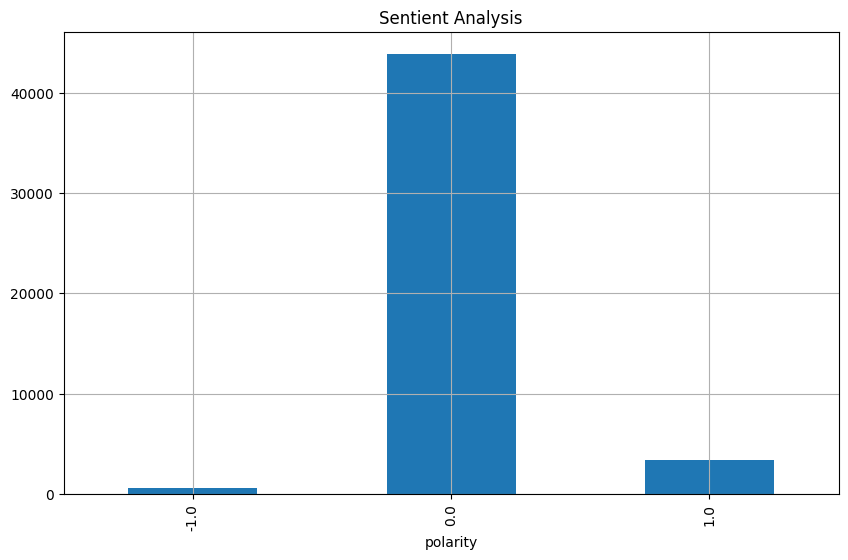

In [290]:
plt.figure(figsize=(10, 6))
df["polarity"].value_counts().sort_index().plot(kind="bar",
                                                      title="Sentient Analysis")
plt.grid()
plt.show()

# Висновок

Всі три моделі працюють досить добре. Перша, можливо, не буде так добре розрізняти якісь нові коментарі, адже навчена на основі оцінок, а не словах.

Також, багато позитивних коментарів можна сплутати з нейтральними і навпаки. Хоча, можливо, машині краще знати.

## Знаходження ціни з коментаря

In [ ]:
data

In [293]:
data = data[~data["review_comment_message"].isnull()]
data

,review_score,review_comment_title,review_comment_message,price,product_category_name_english,review_creation_date
4,5,NaN,Parabéns lojas lannister adorei comprar pela I...,1199.00,sports_leisure,2018-03-01 00:00:00
5,5,NaN,Estou satisfeito com a compra. A empresa é sér...,1199.00,sports_leisure,2017-12-12 00:00:00
6,5,NaN,Tudo correu dentro do previsto. Obrigada!,1199.00,sports_leisure,2018-02-23 00:00:00
7,4,Muito bom.,Recebi exatamente o que esperava. As demais en...,34.90,sports_leisure,2018-06-07 00:00:00
8,1,NaN,Tem que ser mais rapido a entrega,34.90,sports_leisure,2018-04-06 00:00:00
...,...,...,...,...,...,...
111679,5,Otimo,"Muito rapida a entrega ,perfeito",39.90,arts_and_craftmanship,2018-07-26 00:00:00
111681,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",19.00,arts_and_craftmanship,2018-07-28 00:00:00
111682,3,A FOLHA NAO FRISA,"Um dos frisadores que comprei, especificamente...",39.90,arts_and_craftmanship,2018-07-28 00:00:00
111684,4,NaN,Envio muito rápido. Recomendo.,183.29,security_and_services,2017-02-15 00:00:00


In [ ]:
'''PAGUEI CASAL KING R$ 99,00 - NÂO CASAL PADRAO. QUERO TROCA URGENTE.'''

In [ ]:
sentences = ""

for i in data["review_comment_message"].values:
  sentences += i.strip() + "\n"

print(sentences)

In [ ]:
import re


# Регулярний вираз для знаходження ціни в коментарі

pattern = r'.+[ ]?[R]?\$[ ]?\d+\,\d+[ ].+|.+[ ]?\d+\,\d+.+[R]?\$.+'


result = re.findall(pattern, sentences)
print(result)

In [320]:
print(len(result))

30


In [321]:
for i in result:
  print(i)

Aguardo solução protocolo sobre valor de compra divergente da Empresa stark. Valor da compra cobrado a vista de R$352,95 e na fatura cobrado a mais em R$381,25
Aguardo solução protocolo sobre valor de compra divergente da Empresa stark. Valor da compra cobrado a vista de R$352,95 e na fatura cobrado a mais em R$381,25
Aguardo solução protocolo sobre valor de compra divergente da Empresa stark. Valor da compra cobrado a vista de R$352,95 e na fatura cobrado a mais em R$381,25
1 unidade - R$ 269,00 cada
Quero o dinheiro de volta acrescido de R$20,20 da postagem que tive que pagar.
PAGUEI CASAL KING R$ 99,00 - NÂO CASAL PADRAO. QUERO TROCA URGENTE.
1 unidade - R$ 35,00 cada
PAGUEI CASAL KING R$ 99,00 - NÂO CASAL PADRAO. QUERO TROCA URGENTE.
o produto demorou MUITO PARA CHEGAro q NÃO É COMUM TRATANDO-SE DE lannister.COM já conheciaa escovae não entendo pq tem preços disparatados como os que paguei. R$ 128, R$50,00, R$55, etc+ frete.
o produto demorou MUITO PARA CHEGAro q NÃO É COMUM TRATAN

## Функція, яка приймає текстовий коментар і виводить ціну

In [327]:
def find_price(comment):

  pattern = r'[R]?\$[ ]?\d+\,\d+|\d+\,\d+[R]?\$'
  result = re.findall(pattern, comment)

  return result

In [328]:
result = find_price(sentences)